In [14]:
import numpy as np  # Our lovely matrix lib
import glob  # Used to find files.
import os  # Used for many things, in this case for joining a file to a path.
import sys  # Used for any system commands


from osgeo import gdal  # Our geospatial data abstraction lib.
from osgeo import gdalconst
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
BUFFER_SIZE = 1
BP = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
TILE = 'h11v10'

In [61]:
file = [fv for fv in glob.glob(os.path.join(BP, 'MOD44W_{}_min2000_2019.tif'.format(TILE)))][0]
file

'/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h11v10_min2000_2019.tif'

Reading in /att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h11v10_min2000_2019.tif
Shape: (4800, 4800)
Num of 1s:  2406762
Num of 0s:  20633238
Num of 250s:  0


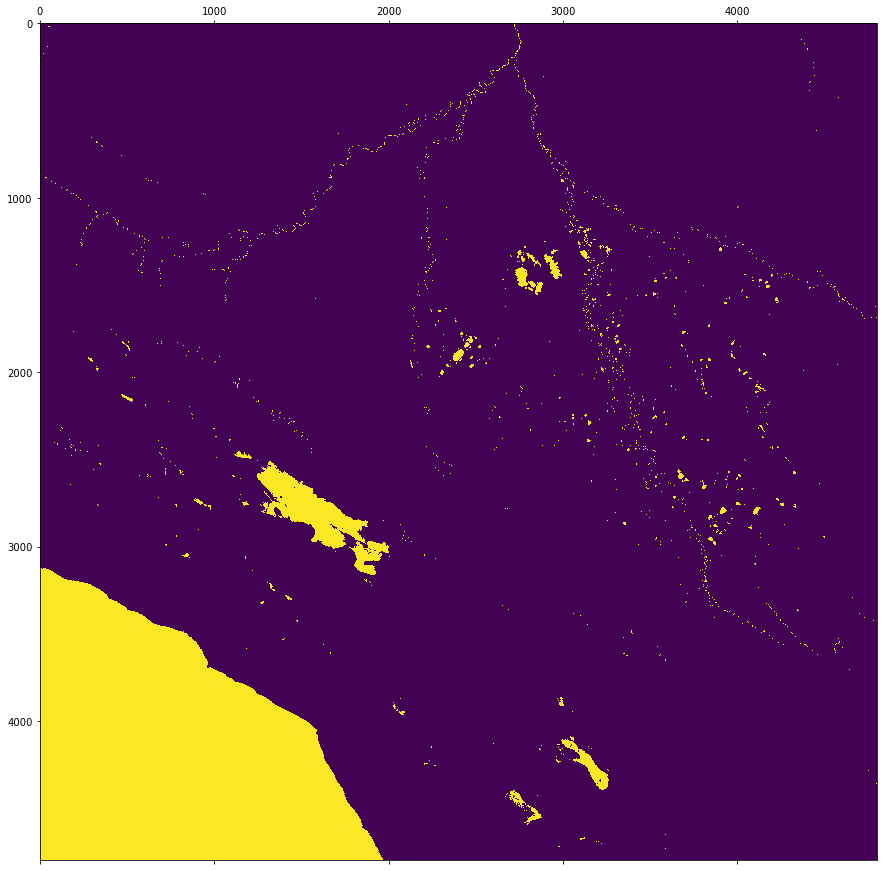

In [62]:
print('Reading in {}'.format(file))
dataImg = gdal.Open(file, gdal.GA_ReadOnly)
dataGeoTransform = dataImg.GetGeoTransform()
dataProjection = dataImg.GetProjection()
numColsData = dataImg.RasterXSize
numRowsData = dataImg.RasterYSize
waterMask = dataImg.GetRasterBand(1).ReadAsArray()
dataImg = None
print('Shape: ({}, {})'.format(numColsData, numRowsData))
print('Num of 1s: ', np.count_nonzero(waterMask == 1))
print('Num of 0s: ', np.count_nonzero(waterMask == 0))
print('Num of 250s: ', np.count_nonzero(waterMask == 250))
waterMaskMatrix = waterMask
plt.figure(figsize=(15, 15))
plt.matshow(np.where(waterMaskMatrix==250, -1, waterMaskMatrix), fignum=1)

In [63]:
inputMask = np.where(waterMask == 250, -np.inf, waterMask)
print('Num of 1s: ', np.count_nonzero(inputMask == 1))
print('Num of 0s: ', np.count_nonzero(inputMask == 0))
print('Num of 250s: ', np.count_nonzero(inputMask == -np.inf))

Num of 1s:  2406762
Num of 0s:  20633238
Num of 250s:  0


Num of 1s:  2565067
Num of 0s:  20474933
Num of 250s:  0


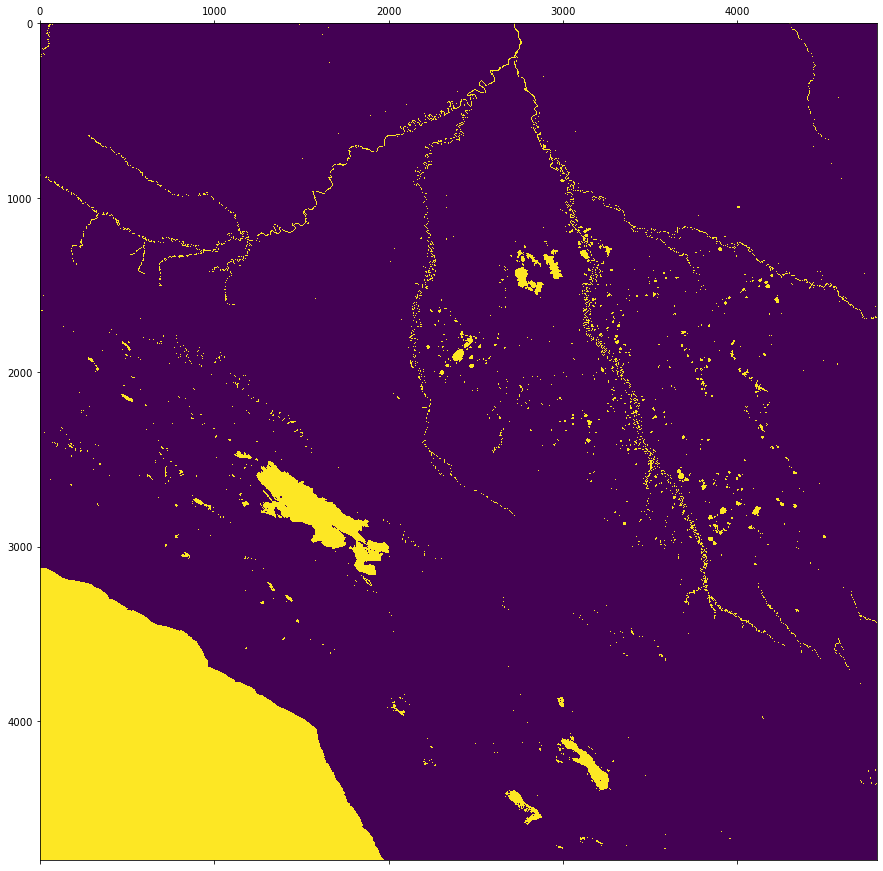

In [64]:
inversedInput = inputMask
filtered = maximum_filter(inversedInput, size=2*BUFFER_SIZE+1, mode='constant', cval=0)
filtered = np.where(waterMask == 250, 250, filtered)
print('Num of 1s: ', np.count_nonzero(filtered == 1))
print('Num of 0s: ', np.count_nonzero(filtered == 0))
print('Num of 250s: ', np.count_nonzero(filtered == 250))
plt.figure(figsize=(15, 15))
plt.matshow(np.where(filtered==250, -1, filtered), fignum=1)

(4800, 4800)
Num of 1s:  158305
Num of 0s:  22881695


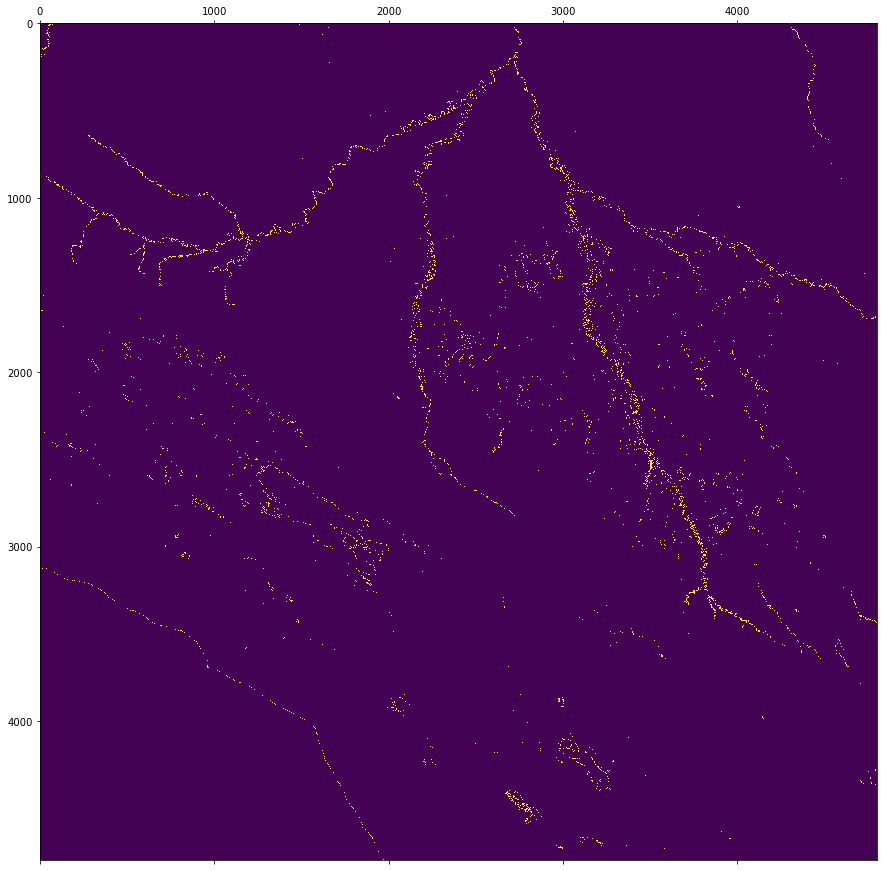

In [65]:
diff = np.where((filtered == 1)&(inputMask==0), 1, 0)
diff = np.where(waterMask == 250, waterMask, diff)
print(diff.shape)
print('Num of 1s: ', np.count_nonzero(diff == 1))
print('Num of 0s: ', np.count_nonzero(diff == 0))
plt.figure(figsize=(15, 15))
plt.matshow(np.where(diff==250, -1, diff), fignum=1)

In [66]:
path = os.path.join('/att/nobackup/cssprad1/projects/modis_water/data/water_masks/AdjacentMin2000_2019', file.split('/')[-1].split('.tif')[0]+'_adjacent.tif')
path

'/att/nobackup/cssprad1/projects/modis_water/data/water_masks/AdjacentMin2000_2019/MOD44W_h11v10_min2000_2019_adjacent.tif'

In [67]:
ds = gdal.Open(file, gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(path, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(diff)
outDs.FlushCache()
outDs = None
outBand = None
driver = None


Transform
(-7783653.36, 231.65635, 0.0, -1111950.48, 0.0, -231.65635)
Projection
PROJCS["Sinusoidal",GEOGCS["Sphere",DATUM["Sphere",SPHEROID["Sphere",6371000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


In [68]:
ds = gdal.Open(path)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
output = arr
ds = None

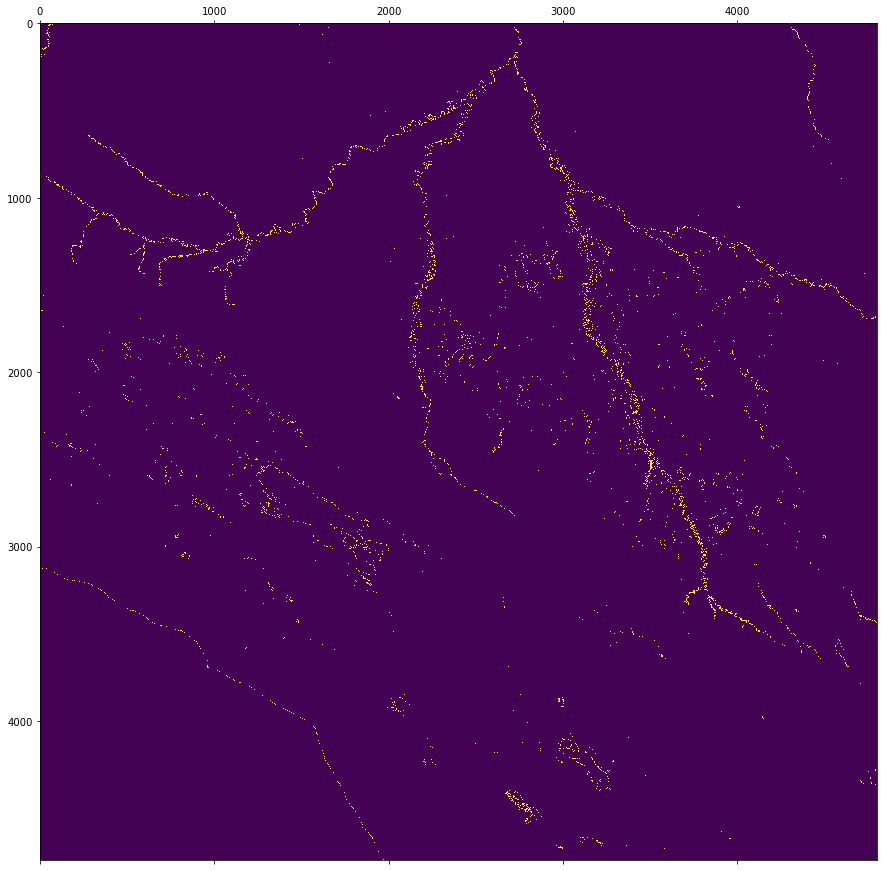

In [69]:
plt.figure(figsize=(15, 15))
plt.matshow(np.where(output==250, -1, output), fignum=1)